# Let's Face It 

**Team Members:** Georgiy Sekretaryuk, Rafael Arbex-Murut, Yeshwanth Somu

**Data Set:** Facial Recognition Dataset
- https://www.kaggle.com/datasets/apollo2506/facial-recognition-dataset?select=Testing

**Data Set Description:**

This dataset contains folders pertaining to different expressions of the human face, such as Surprise, Anger, Happiness, Sad, Neutral, Fear. The training set consists of 28,079 samples in total with the testing set consisting of 7,178 samples in total. The data consists of 48x48 pixel grayscale images of faces. The faces have been automatically registered so that the face is more or less centered and occupies about the same amount of space in each image. The purpose of this project is to analyze facial images to predict emotion.

**Number of Attributes:** 2304

**Attribute Description:** Each attribute is a grayscale value of each of the 48 x 48 pixels.

**Data Source:** Kaggle

In [3]:
# SETUP

import os
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns  # for nicer plots
sns.set(style="darkgrid")  # default style
import tensorflow as tf
from tensorflow import keras
from keras import metrics
from sklearn import metrics
tf.get_logger().setLevel('INFO')

### Loading Data

In [4]:
# Function to load images from a folder
def load_images_from_folder(folder_path, label_mapping):
    images = []
    labels = []

    #load each image file
    for filename in os.listdir(folder_path):
        img = Image.open(os.path.join(folder_path, filename))

        #check if loaded properly
        if img is not None:

            images.append(np.array(img)) #turn image to array
            # print(folder_path)
            folder_path = folder_path.replace("\\", "/")
            folder_name = folder_path.split("/")[-1]  # Extract folder name from path
            # print(folder_name)
            label = label_mapping[folder_name]  # Assign label based on folder name
            labels.append(label)  # Assign the folder index as the label

    return images, labels

def load_dataset(data_folder, return_label_names=False):
    X = []
    Y = []

    label_mapping = {}  # Dictionary to map folder names to label values
    label_counter = 0

    #cycle through each folder, get folder path
    folders = ["Angry", "Fear", "Happy", "Neutral", "Sad", "Suprise"]
    # for folder_name in os.listdir(data_folder):
    for folder_name in folders:
        folder_path = os.path.join(data_folder, folder_name)
        # print("Load_dataset is looping through", folder_path)

        #check if a folder or a stray file
        if os.path.isdir(folder_path):

            #count folders to assign index
            label_mapping[folder_name] = label_counter
            label_counter += 1

            #load images and labels, add to X/Y list
            images, labels = load_images_from_folder(folder_path, label_mapping)
            X.extend(images)
            Y.extend(labels)
    
        else:
            print(f"{folder_path} is not a folder.")

    #pull out label names
    label_names = list(label_mapping.keys())

    if return_label_names:
        label_names = list(label_mapping.keys())
        return np.array(X), np.array(Y), label_names
    else:
        return np.array(X), np.array(Y)

# Load the training dataset
train_folder = 'data/Training/Training'
X_train, Y_train, label_names = load_dataset(train_folder, return_label_names=True)

# Load the testing dataset
test_folder = 'data/Testing/Testing'
X_test, Y_test, = load_dataset(test_folder)

# Flatten the label vectors
Y_train = Y_train.flatten()
Y_test = Y_test.flatten()


In [5]:
print("X_train.shape:", X_train.shape)
print("Y_train.shape:", Y_train.shape)
print("X_test.shape:", X_test.shape)
print("Y_test.shape:", Y_test.shape)

print(label_names)

print(Y_train)

X_train.shape: (28273, 48, 48)
Y_train.shape: (28273,)
X_test.shape: (7067, 48, 48)
Y_test.shape: (7067,)
['Angry', 'Fear', 'Happy', 'Neutral', 'Sad', 'Suprise']
[0 0 0 ... 5 5 5]


In [6]:
pd.Series(Y_train).value_counts()

2    7215
3    4965
4    4830
1    4097
0    3995
5    3171
dtype: int64

In [7]:
len(Y_train[Y_train == 0])

3995

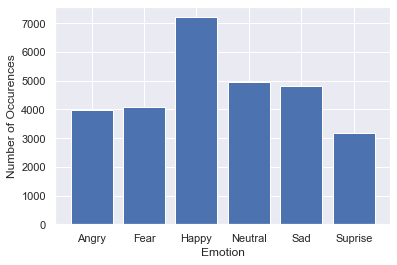

In [8]:
n = [len(Y_train[Y_train == 0]), len(Y_train[Y_train == 1]), len(Y_train[Y_train == 2]), len(Y_train[Y_train == 3]), len(Y_train[Y_train == 4]), len(Y_train[Y_train == 5])]
plt.bar(label_names, n)
plt.xlabel("Emotion")
plt.ylabel ("Number of Occurences")
plt.show()

In [9]:
print(label_names)
n

['Angry', 'Fear', 'Happy', 'Neutral', 'Sad', 'Suprise']


[3995, 4097, 7215, 4965, 4830, 3171]

| Emotion | Non-Faces |
| --- | --- |
| Happy | 2 |
| Suprise | 2 |
| Angry | 2 |
| Neutral | 4 |
| Fear | 2 |
| Sad | 2 |

In [10]:
X_train = X_train / 255
X_test = X_test / 255

### Visualizing Images in Dataset

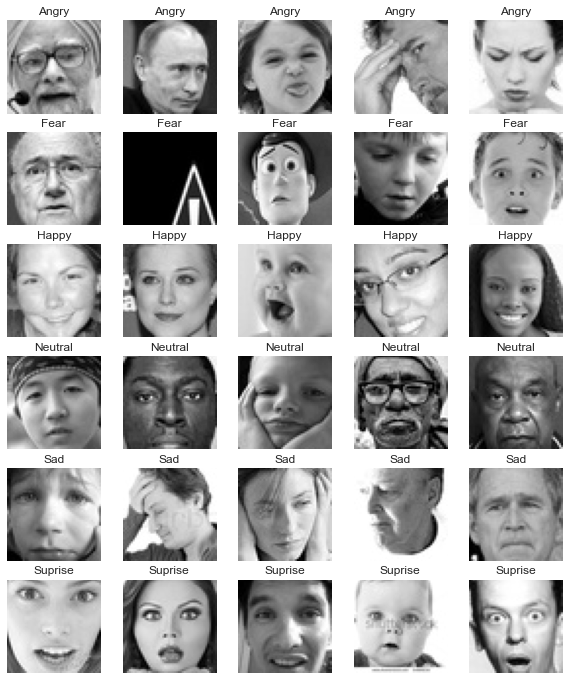

In [9]:
#plot 5 images for each label

num_images_to_show = 5

fig, axs = plt.subplots(len(label_names), ncols=num_images_to_show, figsize=(10, 12))
for label in range(len(label_names)):
    counter = 0 
    for i in range(len(Y_train)):
        if Y_train[i] == label:
            image = X_train[i]
            axs[label, counter].imshow(image, cmap='gray')
            axs[label, counter].set_title(label_names[label])
            axs[label, counter].axis('off')
            counter += 1

            #if loaded 5 images per row/label, break
            if counter == 5:  
                break
plt.show()

### Building the Initial CNN Model

In [10]:
# Apply random shufflying to training examples.
np.random.seed(0)
indices = np.arange(X_train.shape[0])
shuffled_indices = np.random.permutation(indices)
X_train = X_train[shuffled_indices]
Y_train = Y_train[shuffled_indices]

In [11]:
#Checking the shape on data
X_train.shape
Y_train.shape

(28273,)

In [19]:
model = tf.keras.Sequential()

# add first convolution layer to the model
##Same as hw
model.add(tf.keras.layers.Conv2D(
    filters=32,
    kernel_size=(5, 5),
    strides=(1, 1),
    padding='same',
    data_format='channels_last',
    name='conv_1',
    activation='relu'))


# add a max pooling layer with pool size (2,2) and strides of 2
# (this will reduce the spatial dimensions by half)
##Same as hw
model.add(tf.keras.layers.MaxPool2D(
    pool_size=(2, 2),
    name='pool_1'))


# add second convolutional layer
##Same as hw
model.add(tf.keras.layers.Conv2D(
    filters=64,
    kernel_size=(5, 5),
    strides=(1, 1),
    padding='same',
    name='conv_2',
    activation='relu'))

# add second max pooling layer with pool size (2,2) and strides of 2
# (this will further reduce the spatial dimensions by half)
##Same as hw
model.add(tf.keras.layers.MaxPool2D(
    pool_size=(2, 2), name='pool_2')
)


# add a fully connected layer (need to flatten the output of the previous layers first)
##Same as hw
model.add(tf.keras.layers.Flatten()) 
model.add(tf.keras.layers.Dense(
    units=1024,
    name='fc_1', 
    activation='relu'))

# add dropout layer
##Same as hw
model.add(tf.keras.layers.Dropout(
    rate=0.5))

# add the last fully connected layer
# this last layer sets the activation function to "None" in order to output the logits 
# note that passing activation = "sigmoid" will return class memembership probabilities but
# in TensorFlow logits are prefered for numerical stability
# set units=1 to get a single output unit (remember it's a binary classification problem)

##Changed the activation to softmax as this is a multiclass classification
##Units changes to length of label names, should be 6
model.add(tf.keras.layers.Dense(
    units=len(label_names),
    name='fc_2',
    activation='softmax'))


# build model and print summary
##Changed input shape. Set last parameter as 1 since we have a single channel, but not sure how this affects the model
tf.random.set_seed(1)
model.build(input_shape=(None, 48, 48, 1))
model.summary()


##Changes optimizer and loss
model.compile(loss=tf.keras.losses.sparse_categorical_crossentropy, 
                optimizer=tf.keras.optimizers.Adam(), 
                metrics=['accuracy'])


##Changes training and validation data
tf.random.set_seed(1234)
np.random.seed(1234)
history = model.fit(X_train, Y_train,
                    epochs=10, 
                    validation_data=(X_test, Y_test)
)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_1 (Conv2D)             (None, 48, 48, 32)        832       
                                                                 
 pool_1 (MaxPooling2D)       (None, 24, 24, 32)        0         
                                                                 
 conv_2 (Conv2D)             (None, 24, 24, 64)        51264     
                                                                 
 pool_2 (MaxPooling2D)       (None, 12, 12, 64)        0         
                                                                 
 flatten_6 (Flatten)         (None, 9216)              0         
                                                                 
 fc_1 (Dense)                (None, 1024)              9438208   
                                                                 
 dropout_6 (Dropout)         (None, 1024)             

### Final CNN Model

In [14]:
grid_df = pd.DataFrame()


kernel = (5,5)
pool = (2,2)
optimizer = "Adam"
stride = (1,1)

model = tf.keras.Sequential()

# add first convolution layer to the model
##Same as hw
model.add(tf.keras.layers.Conv2D(
    filters=32,
    kernel_size=kernel,
    strides=stride,
    padding='same',
    data_format='channels_last',
    name='conv_1',
    activation='relu'))


# add a max pooling layer with pool size (2,2) and strides of 2
# (this will reduce the spatial dimensions by half)
##Same as hw
model.add(tf.keras.layers.MaxPooling2D(
    pool_size=pool,
    name='pool_1'))


# add second convolutional layer
##Same as hw
model.add(tf.keras.layers.Conv2D(
    filters=64,
    kernel_size=kernel,
    strides=stride,
    padding='same',
    name='conv_2',
    activation='relu'))

# add second max pooling layer with pool size (2,2) and strides of 2
# (this will further reduce the spatial dimensions by half)
##Same as hw
model.add(tf.keras.layers.MaxPooling2D(
    pool_size=pool, name='pool_2')
)


# add a fully connected layer (need to flatten the output of the previous layers first)
##Same as hw
model.add(tf.keras.layers.Flatten()) 
model.add(tf.keras.layers.Dense(
    units=1024,
    name='fc_1', 
    activation='relu'))

# add dropout layer
##Same as hw
model.add(tf.keras.layers.Dropout(
    rate=0.5))

# add the last fully connected layer
# this last layer sets the activation function to "None" in order to output the logits 
# note that passing activation = "sigmoid" will return class memembership probabilities but
# in TensorFlow logits are prefered for numerical stability
# set units=1 to get a single output unit (remember it's a binary classification problem)

##Changed the activation to softmax as this is a multiclass classification
##Units changes to length of label names, should be 6
model.add(tf.keras.layers.Dense(
    units=len(label_names),
    name='fc_2',
    activation='softmax'))


# build model and print summary
##Changed input shape. Set last parameter as 1 since we have a single channel, but not sure how this affects the model
tf.random.set_seed(1)
model.build(input_shape=(None, 48, 48, 1))
# model.summary()


##Changes optimizer and loss
if(optimizer=="Adam"):
    model.compile(loss=tf.keras.losses.sparse_categorical_crossentropy, 
                    optimizer=tf.keras.optimizers.Adam(), 
                    metrics=['accuracy'])
elif(optimizer=="SGD"):
    model.compile(loss=tf.keras.losses.sparse_categorical_crossentropy, 
                    optimizer=tf.keras.optimizers.SGD(), 
                    metrics=['accuracy'])


##Changes training and validation data
tf.random.set_seed(1234)
np.random.seed(1234)
history = model.fit(X_train, Y_train,
                    epochs=10, 
                    validation_data=(X_test, Y_test)
)

# grid_df = grid_df.append({"Kernel Size": str(kernel), "Pool Size": str(pool), "Strides": str(stride), "Optimizer": optimizer, "Val Accuracy": str(history.history["val_accuracy"][-1])}, ignore_index=True)

print("\n")

print("Finished running: ", {"Kernel Size": str(kernel), "Pool Size": str(pool), "Strides": str(stride), "Optimizer": optimizer, "Val Accuracy": str(history.history["val_accuracy"][-1])})




Epoch 1/10
884/884 [==============================] - 90s 101ms/step - loss: 1.5584 - accuracy: 0.3712 - val_loss: 1.4057 - val_accuracy: 0.4439
Epoch 2/10
884/884 [==============================] - 92s 104ms/step - loss: 1.3557 - accuracy: 0.4685 - val_loss: 1.3015 - val_accuracy: 0.4900
Epoch 3/10
884/884 [==============================] - 92s 104ms/step - loss: 1.2409 - accuracy: 0.5204 - val_loss: 1.2580 - val_accuracy: 0.5110
Epoch 4/10
884/884 [==============================] - 92s 105ms/step - loss: 1.1337 - accuracy: 0.5691 - val_loss: 1.2330 - val_accuracy: 0.5299
Epoch 5/10
884/884 [==============================] - 92s 104ms/step - loss: 1.0233 - accuracy: 0.6151 - val_loss: 1.2335 - val_accuracy: 0.5370
Epoch 6/10
884/884 [==============================] - 92s 104ms/step - loss: 0.8933 - accuracy: 0.6690 - val_loss: 1.2322 - val_accuracy: 0.5489
Epoch 7/10
884/884 [==============================] - 92s 105ms/step - loss: 0.7547 - accuracy: 0.7249 - val_loss: 1.2941 - val_ac

In [16]:
test_predictions = np.argmax(model.predict(X_test), axis=-1)
print(test_predictions)

221/221 [==============================] - 3s 14ms/step
[4 3 4 ... 5 1 5]


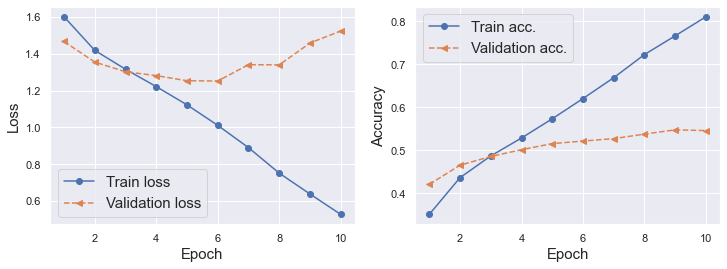

In [21]:
hist = history.history
x_arr = np.arange(len(hist['loss'])) + 1

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist['loss'], '-o', label='Train loss')
ax.plot(x_arr, hist['val_loss'], '--<', label='Validation loss')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)

ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist['accuracy'], '-o', label='Train acc.')
ax.plot(x_arr, hist['val_accuracy'], '--<', label='Validation acc.')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Accuracy', size=15)
plt.show()

In [24]:
## Test Data Accuracy

test_results = model.evaluate(X_test, Y_test)
print('\nTest Acc. {:.2f}%'.format(test_results[1]*100))

221/221 [==============================] - 3s 14ms/step - loss: 1.5243 - accuracy: 0.5458

Test Acc. 54.58%


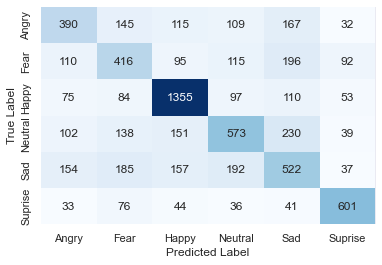

              precision    recall  f1-score   support

           0      0.451     0.407     0.428       958
           1      0.398     0.406     0.402      1024
           2      0.707     0.764     0.734      1774
           3      0.511     0.465     0.487      1233
           4      0.412     0.419     0.415      1247
           5      0.704     0.723     0.713       831

    accuracy                          0.546      7067
   macro avg      0.531     0.531     0.530      7067
weighted avg      0.541     0.546     0.543      7067



In [22]:
# Create a confusion matrix as a 2D array.
confusion_matrix = tf.math.confusion_matrix(Y_test, test_predictions)

# Use a heatmap plot to display it.
ax = sns.heatmap(confusion_matrix, annot=True, fmt='.4g', cmap='Blues',
                 xticklabels=label_names, yticklabels=label_names, cbar=False)

# Add axis labels.
ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.show()

print(metrics.classification_report(Y_test, test_predictions, digits=3))

--------

## Comparative Logistic Regression Model

In [13]:
model = tf.keras.Sequential()

# add first convolution layer to the model
##Same as hw
model.add(tf.keras.layers.Conv2D(
    filters=32,
    kernel_size=(5, 5),
    strides=(1, 1),
    padding='same',
    data_format='channels_last',
    name='conv_1',
    activation='relu'))


# add a max pooling layer with pool size (2,2) and strides of 2
# (this will reduce the spatial dimensions by half)
##Same as hw
model.add(tf.keras.layers.MaxPool2D(
    pool_size=(5,5),
    name='pool_1'))


# add second convolutional layer
##Same as hw
model.add(tf.keras.layers.Conv2D(
    filters=64,
    kernel_size=(5, 5),
    strides=(1, 1),
    padding='same',
    name='conv_2',
    activation='relu'))

# add second max pooling layer with pool size (2,2) and strides of 2
# (this will further reduce the spatial dimensions by half)
##Same as hw
model.add(tf.keras.layers.MaxPool2D(
    pool_size=(5,5), name='pool_2')
)


# add a fully connected layer (need to flatten the output of the previous layers first)
##Same as hw
model.add(tf.keras.layers.Flatten()) 
model.add(tf.keras.layers.Dense(
    units=1024,
    name='fc_1', 
    activation='relu'))

# add dropout layer
##Same as hw
model.add(tf.keras.layers.Dropout(
    rate=0.5))

# add the last fully connected layer
# this last layer sets the activation function to "None" in order to output the logits 
# note that passing activation = "sigmoid" will return class memembership probabilities but
# in TensorFlow logits are prefered for numerical stability
# set units=1 to get a single output unit (remember it's a binary classification problem)

##Changed the activation to softmax as this is a multiclass classification
##Units changes to length of label names, should be 6
model.add(tf.keras.layers.Dense(
    units=len(label_names),
    name='fc_2',
    activation='softmax'))


# build model and print summary
##Changed input shape. Set last parameter as 1 since we have a single channel, but not sure how this affects the model
tf.random.set_seed(1)
model.build(input_shape=(None, 48, 48, 1))
model.summary()


##Changes optimizer and loss
model.compile(loss=tf.keras.losses.sparse_categorical_crossentropy, 
                optimizer=tf.keras.optimizers.Adam(), 
                metrics=['accuracy'])


##Changes training and validation data
tf.random.set_seed(1234)
np.random.seed(1234)
history = model.fit(X_train, Y_train,
                    epochs=10, 
                    validation_data=(X_test, Y_test)
)


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_1 (Conv2D)             (None, 48, 48, 32)        832       
                                                                 
 pool_1 (MaxPooling2D)       (None, 9, 9, 32)          0         
                                                                 
 conv_2 (Conv2D)             (None, 9, 9, 64)          51264     
                                                                 
 pool_2 (MaxPooling2D)       (None, 1, 1, 64)          0         
                                                                 
 flatten_1 (Flatten)         (None, 64)                0         
                                                                 
 fc_1 (Dense)                (None, 1024)              66560     
                                                                 
 dropout_1 (Dropout)         (None, 1024)             

## Pixel Analysis

In [ ]:
first_coord = 24
second_coord = 24

angry_faces = X_train[np.where(Y_train == 0)]
angry_center = []
for i in range(0,len(angry_faces)): angry_center.append(angry_faces[i][first_coord,second_coord])
print("Mean of all angry images' center pixel is: ", np.mean(angry_center))
print("Standard Deviation of all sneaker images' center pixel is: ", np.std(angry_center))
print("\n")


fear_faces = X_train[np.where(Y_train == 1)]
fear_center = []
for i in range(0,len(fear_faces)): fear_center.append(fear_faces[i][first_coord,second_coord])
print("Mean of all fear images' center pixel is: ", np.mean(fear_center))
print("Standard Deviation of all fear images' center pixel is: ", np.std(fear_center))
print("\n")

happy_faces = X_train[np.where(Y_train == 2)]
happy_center = []
for i in range(0,len(happy_faces)): happy_center.append(happy_faces[i][first_coord,second_coord])
print("Mean of all happy images' center pixel is: ", np.mean(happy_center))
print("Standard Deviation of all happy images' center pixel is: ", np.std(happy_center))
print("\n")

neutral_faces = X_train[np.where(Y_train == 3)]
neutral_center = []
for i in range(0,len(neutral_faces)): neutral_center.append(neutral_faces[i][first_coord,second_coord])
print("Mean of all neutral images' center pixel is: ", np.mean(neutral_center))
print("Standard Deviation of all neutral images' center pixel is: ", np.std(neutral_center))
print("\n")

sad_faces = X_train[np.where(Y_train == 4)]
sad_center = []
for i in range(0,len(sad_faces)): sad_center.append(sad_faces[i][first_coord,second_coord])
print("Mean of all sad images' center pixel is: ", np.mean(sad_center))
print("Standard Deviation of all sad images' center pixel is: ", np.std(sad_center))
print("\n")

surprise_faces = X_train[np.where(Y_train == 5)]
surprise_center = []
for i in range(0,len(surprise_faces)): surprise_center.append(surprise_faces[i][first_coord,second_coord])
print("Mean of all suprise images' center pixel is: ", np.mean(surprise_center))
print("Standard Deviation of all suprise images' center pixel is: ", np.std(surprise_center))
print("\n")

In [ ]:
first_coord = 12
second_coord = 30

angry_faces = X_train[np.where(Y_train == 0)]
angry_center = []
for i in range(0,len(angry_faces)): angry_center.append(angry_faces[i][first_coord,second_coord])
print("Mean of all angry images' center pixel is: ", np.mean(angry_center))
print("Standard Deviation of all sneaker images' center pixel is: ", np.std(angry_center))
print("\n")


fear_faces = X_train[np.where(Y_train == 1)]
fear_center = []
for i in range(0,len(fear_faces)): fear_center.append(fear_faces[i][first_coord,second_coord])
print("Mean of all fear images' center pixel is: ", np.mean(fear_center))
print("Standard Deviation of all fear images' center pixel is: ", np.std(fear_center))
print("\n")

happy_faces = X_train[np.where(Y_train == 2)]
happy_center = []
for i in range(0,len(happy_faces)): happy_center.append(happy_faces[i][first_coord,second_coord])
print("Mean of all happy images' center pixel is: ", np.mean(happy_center))
print("Standard Deviation of all happy images' center pixel is: ", np.std(happy_center))
print("\n")

neutral_faces = X_train[np.where(Y_train == 3)]
neutral_center = []
for i in range(0,len(neutral_faces)): neutral_center.append(neutral_faces[i][first_coord,second_coord])
print("Mean of all neutral images' center pixel is: ", np.mean(neutral_center))
print("Standard Deviation of all neutral images' center pixel is: ", np.std(neutral_center))
print("\n")

sad_faces = X_train[np.where(Y_train == 4)]
sad_center = []
for i in range(0,len(sad_faces)): sad_center.append(sad_faces[i][first_coord,second_coord])
print("Mean of all sad images' center pixel is: ", np.mean(sad_center))
print("Standard Deviation of all sad images' center pixel is: ", np.std(sad_center))
print("\n")

surprise_faces = X_train[np.where(Y_train == 5)]
surprise_center = []
for i in range(0,len(surprise_faces)): surprise_center.append(surprise_faces[i][first_coord,second_coord])
print("Mean of all suprise images' center pixel is: ", np.mean(surprise_center))
print("Standard Deviation of all suprise images' center pixel is: ", np.std(surprise_center))
print("\n")

In [ ]:
label_names

## Appendix

In [ ]:
# grid_df = pd.DataFrame()


# for kernel in [(3,3), (4,4), (5,5), (6,6), (7,7)]:
#     for pool in [(2,2), (3,3), (4,4), (5,5)]:
#         for optimizer in ["Adam", "SGD"]:
#             for stride in [(1,1)]:
#                 try:
#                     print(kernel, pool, optimizer)

#                     model = tf.keras.Sequential()

#                     # add first convolution layer to the model
#                     ##Same as hw
#                     model.add(tf.keras.layers.Conv2D(
#                         filters=32,
#                         kernel_size=kernel,
#                         strides=stride,
#                         padding='same',
#                         data_format='channels_last',
#                         name='conv_1',
#                         activation='relu'))


#                     # add a max pooling layer with pool size (2,2) and strides of 2
#                     # (this will reduce the spatial dimensions by half)
#                     ##Same as hw
#                     model.add(tf.keras.layers.MaxPooling2D(
#                         pool_size=pool,
#                         name='pool_1'))


#                     # add second convolutional layer
#                     ##Same as hw
#                     model.add(tf.keras.layers.Conv2D(
#                         filters=64,
#                         kernel_size=kernel,
#                         strides=stride,
#                         padding='same',
#                         name='conv_2',
#                         activation='relu'))

#                     # add second max pooling layer with pool size (2,2) and strides of 2
#                     # (this will further reduce the spatial dimensions by half)
#                     ##Same as hw
#                     model.add(tf.keras.layers.MaxPooling2D(
#                         pool_size=pool, name='pool_2')
#                     )


#                     # add a fully connected layer (need to flatten the output of the previous layers first)
#                     ##Same as hw
#                     model.add(tf.keras.layers.Flatten()) 
#                     model.add(tf.keras.layers.Dense(
#                         units=1024,
#                         name='fc_1', 
#                         activation='relu'))

#                     # add dropout layer
#                     ##Same as hw
#                     model.add(tf.keras.layers.Dropout(
#                         rate=0.5))

#                     # add the last fully connected layer
#                     # this last layer sets the activation function to "None" in order to output the logits 
#                     # note that passing activation = "sigmoid" will return class memembership probabilities but
#                     # in TensorFlow logits are prefered for numerical stability
#                     # set units=1 to get a single output unit (remember it's a binary classification problem)

#                     ##Changed the activation to softmax as this is a multiclass classification
#                     ##Units changes to length of label names, should be 6
#                     model.add(tf.keras.layers.Dense(
#                         units=len(label_names),
#                         name='fc_2',
#                         activation='softmax'))


#                     # build model and print summary
#                     ##Changed input shape. Set last parameter as 1 since we have a single channel, but not sure how this affects the model
#                     tf.random.set_seed(1)
#                     model.build(input_shape=(None, 48, 48, 1))
#                     # model.summary()


#                     ##Changes optimizer and loss
#                     if(optimizer=="Adam"):
#                         model.compile(loss=tf.keras.losses.sparse_categorical_crossentropy, 
#                                         optimizer=tf.keras.optimizers.Adam(learning_rate=.01), 
#                                         metrics=['accuracy'])
#                     else:
#                         model.compile(loss=tf.keras.losses.sparse_categorical_crossentropy, 
#                                         optimizer=tf.keras.optimizers.SGD(learning_rate=.01), 
#                                         metrics=['accuracy'])


#                     ##Changes training and validation data
#                     tf.random.set_seed(1234)
#                     np.random.seed(1234)
#                     history = model.fit(X_train, Y_train,
#                                         epochs=10, 
#                                         validation_data=(X_test, Y_test), verbose=0
#                     )

#                     grid_df = grid_df.append({"Kernel Size": str(kernel), "Pool Size": str(pool), "Strides": str(stride), "Optimizer": optimizer, "Val Accuracy": str(history.history["val_accuracy"][-1])}, ignore_index=True)

#                     print("Finished running: ", {"Kernel Size": str(kernel), "Pool Size": str(pool), "Strides": str(stride), "Optimizer": optimizer, "Val Accuracy": str(history.history["val_accuracy"][-1])})
#                     print("\n")
#                 except:
#                     print("ERROR WITH: ", {"Kernel Size": str(kernel), "Pool Size": str(pool), "Strides": str(stride), "Optimizer": optimizer, "Val Accuracy": str(history.history["val_accuracy"][-1])})
#                     print("\n")

